

# **Keras - Transfer Learning com Cats vs Dogs**

---

Nesta lição, aprenderemos como configurar geradores de dados para carregar nosso próprio conjunto de dados e treinar um classificador usando o Keras.
1. Compreender as camadas treináveis de uma rede neural
2. Configurar nossos dados
3. Construir nosso modelo para transferência de aprendizado
4. Realizar o ajuste fino

In [1]:
# Import of libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras

2026-02-01 21:33:50.910219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-01 21:33:51.498596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769992431.745490    1332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769992431.795004    1332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769992432.244589    1332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## **Camadas treináveis**

As camadas e os modelos têm **três** atributos de peso:

- `weights` é a lista de todas as variáveis de peso da camada.
- `trainable_weights` é a lista daquelas que devem ser atualizadas (por meio do gradiente descendente) para minimizar a perda durante o treinamento.
- `non_trainable_weights` é a lista daqueles que não devem ser treinados.
 Normalmente, eles são atualizados pelo modelo durante a passagem para frente.

**Exemplo: a camada `Dense` tem 2 pesos treináveis (kernel e bias)**

In [2]:
layer = keras.layers.Dense(4)

# Create the weights using layer.build
layer.build((None, 2))  

print(f'Number of weights: {len(layer.weights)}')
print(f'Number of trainable_weights: {len(layer.trainable_weights)}')
print(f'Number of non_trainable_weights: {len(layer.non_trainable_weights)}')

I0000 00:00:1769992439.939089    1332 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4947 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Number of weights: 2
Number of trainable_weights: 2
Number of non_trainable_weights: 0


Todas as camadas são treináveis, com exceção da **BatchNormalization**. Ela usa pesos não treináveis para acompanhar a média e a variância de suas entradas durante o treinamento. 

**Camadas e modelos** também apresentam um atributo booleano `trainable`. 

Seu valor pode ser alterado definindo `layer.trainable` como `False`, o que move todos os pesos da camada de treináveis para não treináveis.  

Isso é chamado de **“congelar”** a camada: o estado de uma camada congelada não
será atualizado durante o treinamento (seja ao treinar com `fit()` ou ao treinar com
 qualquer loop personalizado que dependa de `trainable_weights` para aplicar atualizações de gradiente).

### **Exemplo: definindo `trainable` como `False`**

In [3]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

I0000 00:00:1769992447.094694    1414 service.cc:152] XLA service 0x761eec004eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769992447.094743    1414 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-01 21:34:07.156178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1769992447.284076    1414 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step - loss: 0.0559


I0000 00:00:1769992447.526007    1414 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [4]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()

if initial_layer1_weights_values[0].all() == final_layer1_weights_values[0].all():
  print('Weights unchanged')

if initial_layer1_weights_values[1].all() == final_layer1_weights_values[1].all():
  print('Weights unchanged')

Weights unchanged
Weights unchanged


**Observação**: **`.trianable` é recursivo**, o que significa que, em um modelo ou em qualquer camada que tenha subcamadas, todas as camadas filhas também se tornam não treináveis.

## **Implementando o aprendizado por transferência**

![](https://github.com/rajeevratan84/ModernComputerVision/blob/main/Screenshot%202021-05-11%20at%2011.49.01%20pm.png?raw=true)

## **Transfer-learning workflow**

1. Instanciamos um **modelo base e carregamos pesos pré-treinados** nele.
2. **Congelamos** todas as camadas no modelo base definindo `trainable = False`.
3. Criamos um **novo modelo sobre** a saída de uma (ou várias) camadas do modelo base.
4. Treinamos seu novo modelo em seu novo conjunto de dados.
O modelo base é um modelo de rede neural convolucional (CNN) com 10 camadas, sendo as duas primeiras camadas convolucionais e as outras oito camadas convolucionais de núcleo fixo. O modelo base tem 1000 camadas e 1000 camadas de saída.

### **Passo 1.carregando os pesos pre treinados do modelo treinado no ImageNet**

In [6]:
!pip install tensorflow_datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 46.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.0 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 67.0 MB/s  0:00:006m0:00:0100:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21580 sha256=ff38fb83f452f8a9ec6fd1945a4be249624facee722ea4e065243d0548783f83
  Stored in directory: /home/gabs/.cache/pip/wheels/e7/e6/28/864bdfee5339dbd6ddcb5a186286a8e217648ec198bdf0097d
Successfully built promise
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 [tensorflow_datasets]nsorflow_datasets]otos]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f'Number of training samples: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test samples: {tf.data.experimental.cardinality(test_ds)}')

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Dataset cats_vs_dogs downloaded and prepared to /home/gabs/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Estas são as primeiras 9 imagens do conjunto de dados de treinamento — como você pode ver, todas elas têm tamanhos diferentes.

2026-02-01 21:37:41.984773: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-01 21:37:42.065643: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


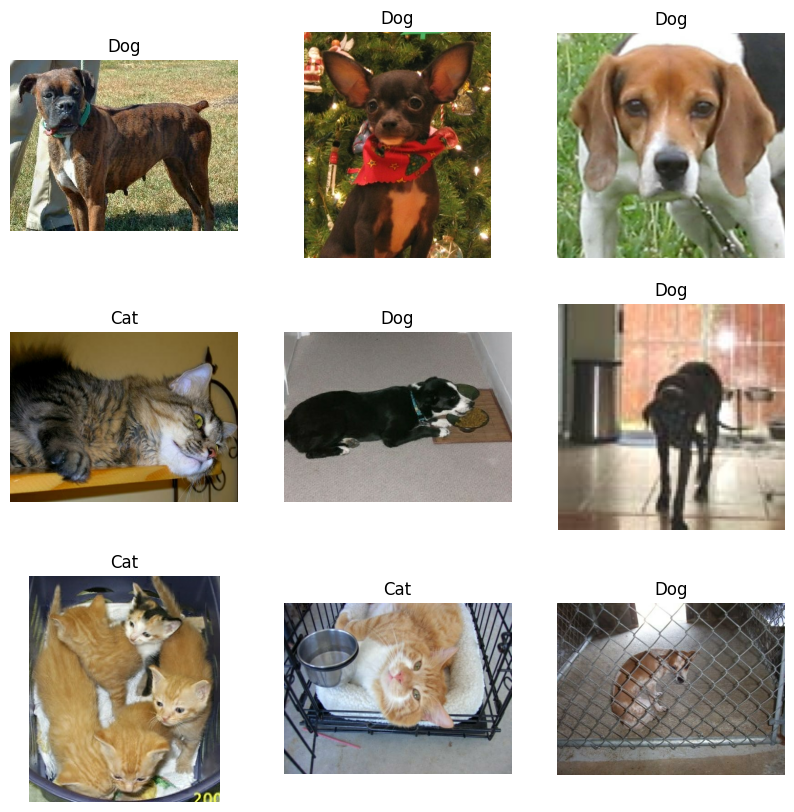

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis("off")

## **Padronizar nossos dados**

- Padronizar para um tamanho de imagem fixo. Escolhemos 150x150.
- Normalizar os valores de pixel entre -1 e 1. Faremos isso usando uma camada de `Normalização` como
 parte do próprio modelo.

In [9]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Agruparemos os dados e utilizaremos cache e pré-busca para otimizar a velocidade de carregamento.

In [10]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### **Introduzir algum aumento aleatório de dados**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

#### **Visualize nossos aumentos de dados**

2026-02-01 21:39:59.521337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2026-02-01 21:40:00.418281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


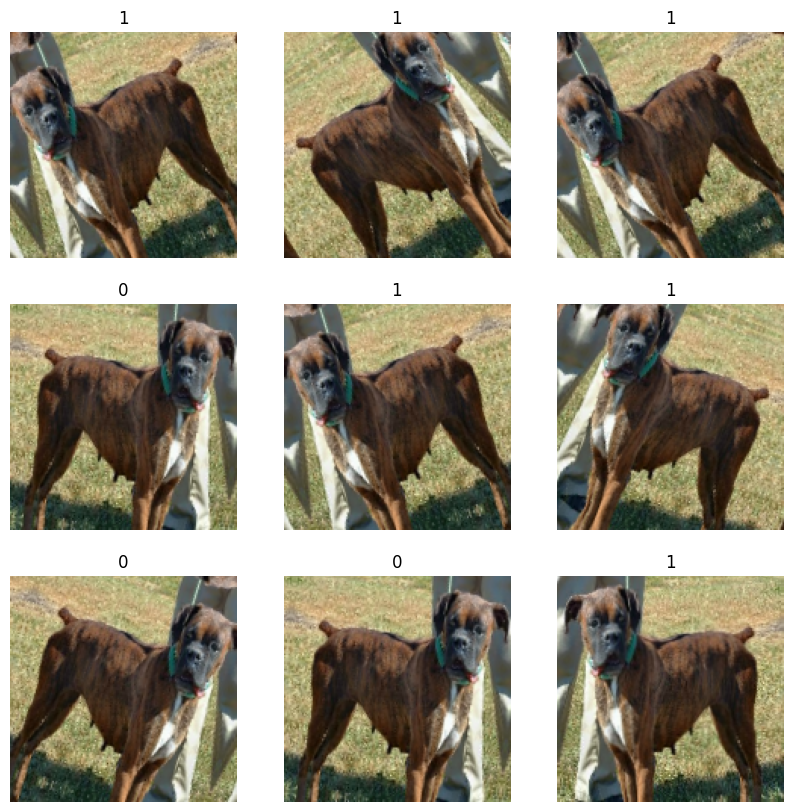

In [14]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **3. Construindo nosso modelo**

Agora vamos construir um modelo que siga o plano que explicamos anteriormente.

Observe que:

- Adicionamos uma camada `Normalização` para dimensionar os valores de entrada (inicialmente no intervalo `[0, 255]`)
 para o intervalo `[-1, 1]`.
- Adicionamos uma camada `Dropout` antes da camada de classificação, para regularização.
- Certificamo-nos de passar `training=False` ao chamar o modelo base, para que
ele seja executado no modo de inferência, de modo que as estatísticas batchnorm não sejam atualizadas
mesmo depois de descongelarmos o modelo base para ajuste fino.

- Usaremos o **Modelo Xception** como nossa base.

In [15]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## **Agora vamos treinar nossa camada superior**

Observe no resumo acima que temos apenas 2.049 parâmetros treináveis.

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - binary_accuracy: 0.8934 - loss: 0.2368 - val_binary_accuracy: 0.9703 - val_loss: 0.0842
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - binary_accuracy: 0.9461 - loss: 0.1281 - val_binary_accuracy: 0.9703 - val_loss: 0.0800
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - binary_accuracy: 0.9526 - loss: 0.1143 - val_binary_accuracy: 0.9708 - val_loss: 0.0775
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - binary_accuracy: 0.9588 - loss: 0.1064 - val_binary_accuracy: 0.9708 - val_loss: 0.0747
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - binary_accuracy: 0.9566 - loss: 0.1129 - val_binary_accuracy: 0.9712 - val_loss: 0.0784
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - binary_accuracy: 0.9562 - loss: 0.1062 - val_binary_accuracy: 0.9738 - val_loss: 0.0731
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - binary_accuracy: 0.9640 - loss: 0.1002 - val_binary_accuracy: 0.9712 - val_loss:

## **4. Fine Tuning**

**Descongelamos** o modelo base e treinamos todo o modelo de ponta a ponta com uma taxa de aprendizagem **baixa**.

**Observações**: embora o modelo base se torne treinável, ele ainda está sendo executado no modo de inferência, pois passamos `training=False` ao chamá-lo quando construímos o modelo. 

Isso significa que as camadas de normalização de lote internas não atualizarão suas estatísticas de lote. Se o fizessem, causariam estragos nas representações aprendidas pelo modelo até o momento.

In [17]:
# Descongele o base_model. Observe que ele continua funcionando no modo de inferência,
# já que passamos `training=False` ao chamá-lo. Isso significa que
# as camadas batchnorm não atualizarão suas estatísticas do batch.
# Isso evita que as camadas batchnorm desfaçam todo o treinamento
# que fizemos até agora.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 124s 308ms/step - binary_accuracy: 0.8668 - loss: 0.3141 - val_binary_accuracy: 0.9566 - val_loss: 0.1118
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 82s 283ms/step - binary_accuracy: 0.9241 - loss: 0.1779 - val_binary_accuracy: 0.9647 - val_loss: 0.0950
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 80s 275ms/step - binary_accuracy: 0.9424 - loss: 0.1376 - val_binary_accuracy: 0.9660 - val_loss: 0.0859
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 79s 273ms/step - binary_accuracy: 0.9560 - loss: 0.1060 - val_binary_accuracy: 0.9695 - val_loss: 0.0817
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 79s 271ms/step - binary_accuracy: 0.9687 - loss: 0.0875 - val_binary_accuracy: 0.9699 - val_loss: 0.0762
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 83s 286ms/step - binary_accuracy: 0.9671 - loss: 0.0804 - val_binary_accuracy: 0.9708 - val_loss: 0.0742
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 84s 287ms/step - binary_accuracy: 0.9769 - loss: 0.0637 - val_binary_accuracy: 0.9742 - v